# Features engineer

In [9]:
import os
import json
import random
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/linear_models/Lasso/model_setting/v2_X2X1"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# 清空 log
with open(LOG_PATH, "w") as f:
    f.write("")

def log(msg):
    """印出並同步寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")

log(f"🚀 Lasso Regression experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  MODEL CONFIGURATION
# ============================================================
model_name = "Lasso"
model_params = {
    "alpha": 0.001,          # ← 你可以稍後用 Optuna 自動調整
    "max_iter": 20000,
    "random_state": SEED
}

# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "model": model_name,
    "params": model_params,
    "folds": folds,
    "target_col": TARGET_COL,
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING LOOP
# ============================================================
results = []
preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split data
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols].values, df_train[TARGET_COL].values
    X_val, y_val     = df_val[feature_cols].values, df_val[TARGET_COL].values

    # ============================================================
    #                  MODEL TRAINING
    # ============================================================
    model = Pipeline([
        ("scaler", StandardScaler()),    
        ("regressor", Lasso(**model_params))
    ])
    model.fit(X_train, y_train)


    # Save model
    model_path = os.path.join(fold_dir, "lasso_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    y_pred = model.predict(X_val)
    df_val["predicted_gex_rank"] = y_pred
    df_val["fold_id"] = fold_idx + 1
    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate Spearman
    overall_spearman = spearmanr(y_val, y_pred)[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })
    # ============================================================
    #                  FEATURE IMPORTANCE (非零特徵分析)
    # ============================================================
    reg = model.named_steps["regressor"]
    coef = reg.coef_
    nonzero_mask = coef != 0
    nonzero_count = np.sum(nonzero_mask)
    zero_count = len(coef) - nonzero_count
    log(f"🔎 Non-zero features: {nonzero_count}/{len(coef)} ({nonzero_count/len(coef)*100:.1f}%)")

    # 建立 DataFrame 方便觀察
    df_coef = pd.DataFrame({
        "feature": feature_cols,
        "coef": coef,
        "abs_coef": np.abs(coef),
        "nonzero": nonzero_mask
    }).sort_values("abs_coef", ascending=False)

    # 儲存每個 fold 的係數結果
    coef_path = os.path.join(fold_dir, "lasso_feature_importance.tsv")
    df_coef.to_csv(coef_path, sep="\t", index=False)
    log(f"💾 Feature importance saved: {coef_path}")

    # （選擇性）顯示前 10 個重要特徵
    log("🏆 Top 10 strongest features:")
    for f, w in df_coef.head(10)[["feature", "coef"]].values:
        log(f"   {f:<40s} {w:+.4f}")



# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions saved (predict_val.tsv)")

overall_val_spearman = spearmanr(
    df_val_full["gex_rank"],
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")

# === Summaries ===
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Lasso Regression experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Lasso Regression experiment started at 2025-10-14 12:54:48
Feature count: 277
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
💾 Model saved: ../results/linear_models/Lasso/model_setting/v2_X2X1\fold_1\lasso_model.pkl
📈 Fold 1 Overall Spearman ρ = 0.7322
   chr12 : ρ = 0.7428
   chr17 : ρ = 0.7163
   chr2  : ρ = 0.7293
   chr22 : ρ = 0.7571
   chr7  : ρ = 0.7292
🔎 Non-zero features: 128/277 (46.2%)
💾 Feature importance saved: ../results/linear_models/Lasso/model_setting/v2_X2X1\fold_1\lasso_feature_importance.tsv
🏆 Top 10 strongest features:
   DNase_ratio_std_rank                     +0.0554
   DNase_tss_autocorr_rank                  +0.0434
   DNase_H3K4me3_interaction_rank           +0.043

In [6]:
import glob

# ============================================================
#                  FEATURE STABILITY ACROSS FOLDS
# ============================================================
log("\n📊 Aggregating feature importances across folds...")

coef_files = glob.glob(os.path.join(EXPERIMENT_DIR, "fold_*/lasso_feature_importance.tsv"))
dfs = [pd.read_csv(f, sep="\t") for f in coef_files]
df_all_coef = pd.concat(dfs, keys=range(1, len(dfs)+1), names=["fold", "idx"])

# 統計每個特徵在幾個 fold 非零、平均係數
feature_summary = (
    df_all_coef.groupby("feature")
    .agg(
        nonzero_folds=("nonzero", "sum"),
        mean_coef=("coef", "mean"),
        mean_abs_coef=("abs_coef", "mean")
    )
    .reset_index()
    .sort_values(["nonzero_folds", "mean_abs_coef"], ascending=[False, False])
)

# 儲存完整表格
summary_path = os.path.join(EXPERIMENT_DIR, "feature_stability_summary.tsv")
feature_summary.to_csv(summary_path, sep="\t", index=False)
log(f"💾 Feature stability summary saved: {summary_path}")

# ============================================================
#                  PRINT ALL NON-ZERO FEATURES
# ============================================================
nonzero_features = feature_summary[feature_summary["nonzero_folds"] > 0]

log(f"\n🧬 Total non-zero features across folds: {len(nonzero_features)}/{len(feature_summary)}")
log("📋 List of all non-zero features:")

for _, row in nonzero_features.iterrows():
    log(f"   {row['feature']:<40s}  folds={int(row['nonzero_folds'])}  mean_coef={row['mean_coef']:+.4f}")



📊 Aggregating feature importances across folds...
💾 Feature stability summary saved: ../results/linear_models/Lasso/model_setting/v2\feature_stability_summary.tsv

🧬 Total non-zero features across folds: 170/277
📋 List of all non-zero features:
   DNase_tss_entropy                         folds=5  mean_coef=-0.0568
   DNase_ratio_std_rank                      folds=5  mean_coef=+0.0283
   DNase_H3K4me3_interaction_rank            folds=5  mean_coef=+0.0270
   DNase_tss_autocorr_rank                   folds=5  mean_coef=+0.0258
   H3K36me3_gene_z_mean_rank                 folds=5  mean_coef=+0.0188
   DNase_tss_entropy_rank                    folds=5  mean_coef=+0.0184
   DNase_promoter_body_delta_rank            folds=5  mean_coef=+0.0158
   H3K4me3_gene_z_std                        folds=5  mean_coef=+0.0157
   H3K36me3_tss_z_mean_rank                  folds=5  mean_coef=-0.0137
   H3K4me3_promoter_body_delta               folds=5  mean_coef=-0.0121
   DNase_gene_autocorr_rank       

In [10]:
import glob

# ============================================================
#                  FEATURE STABILITY ACROSS FOLDS
# ============================================================
log("\n📊 Aggregating feature importances across folds...")

coef_files = glob.glob(os.path.join(EXPERIMENT_DIR, "fold_*/lasso_feature_importance.tsv"))
dfs = [pd.read_csv(f, sep="\t") for f in coef_files]
df_all_coef = pd.concat(dfs, keys=range(1, len(dfs)+1), names=["fold", "idx"])

# 統計每個特徵在幾個 fold 非零、平均係數
feature_summary = (
    df_all_coef.groupby("feature")
    .agg(
        nonzero_folds=("nonzero", "sum"),
        mean_coef=("coef", "mean"),
        mean_abs_coef=("abs_coef", "mean")
    )
    .reset_index()
    .sort_values(["nonzero_folds", "mean_abs_coef"], ascending=[False, False])
)

# 儲存完整表格
summary_path = os.path.join(EXPERIMENT_DIR, "feature_stability_summary.tsv")
feature_summary.to_csv(summary_path, sep="\t", index=False)
log(f"💾 Feature stability summary saved: {summary_path}")

# ============================================================
#                  PRINT ALL NON-ZERO FEATURES
# ============================================================
nonzero_features_2 = feature_summary[feature_summary["nonzero_folds"] > 0]

log(f"\n🧬 Total non-zero features across folds: {len(nonzero_features_2)}/{len(feature_summary)}")
log("📋 List of all non-zero features:")

for _, row in nonzero_features_2.iterrows():
    log(f"   {row['feature']:<40s}  folds={int(row['nonzero_folds'])}  mean_coef={row['mean_coef']:+.4f}")



📊 Aggregating feature importances across folds...
💾 Feature stability summary saved: ../results/linear_models/Lasso/model_setting/v2_X2X1\feature_stability_summary.tsv

🧬 Total non-zero features across folds: 186/277
📋 List of all non-zero features:
   DNase_ratio_std_rank                      folds=5  mean_coef=+0.0554
   DNase_tss_autocorr_rank                   folds=5  mean_coef=+0.0419
   DNase_H3K4me3_interaction_rank            folds=5  mean_coef=+0.0407
   DNase_tss_entropy                         folds=5  mean_coef=-0.0357
   H3K36me3_gene_z_mean_rank                 folds=5  mean_coef=+0.0219
   H3K4me3_tss_entropy_rank                  folds=5  mean_coef=-0.0172
   H3K4me3_ratio_std_rank                    folds=5  mean_coef=-0.0169
   H3K4me3_gene_autocorr_rank                folds=5  mean_coef=+0.0151
   H3K4me3_gene_z_std                        folds=5  mean_coef=+0.0106
   H3K4me1_tss_z_min_rank                    folds=5  mean_coef=-0.0103
   H3K4me3_tss_z_min_rank    

In [13]:
# 取出兩邊的 feature list
features_1 = nonzero_features["feature"].to_list()
features_2 = nonzero_features_2["feature"].to_list()

# 取聯集（去重）
union_features = list(set(features_1) & set(features_2))

print(f"🧬 Total union features: {len(union_features)}")
print(union_features)  # 預覽前 20 個


🧬 Total union features: 125
['H3K36me3_axis_sum_rank', 'tss_length', 'DNase_tss_autocorr_rank', 'H3K4me1_tss_z_min_rank', 'H3K4me1_tss_kurtosis_rank', 'H3K9me3_gene_z_mean', 'H3K36me3_H3K9me3_interaction_rank', 'H3K36me3_gene_z_mean_rank', 'H3K4me3_gene_z_std', 'H3K27ac_gene_slope', 'H3K4me1_gene_z_min_rank', 'H3K27ac_tss_z_min_rank', 'H3K4me3_H3K27me3_interaction', 'H3K36me3_gene_autocorr_rank', 'H3K4me3_gene_entropy_rank', 'H3K4me3_H3K27me3_interaction_rank', 'DNase_tss_skewness_rank', 'H3K27me3_gene_slope', 'DNase_gene_slope', 'H3K4me3_ratio_std_rank', 'H3K27me3_ratio_mean_rank', 'H3K36me3_tss_autocorr_rank', 'H3K36me3_tss_skewness', 'H3K36me3_tss_z_min', 'H3K27ac_gene_slope_rank', 'H3K27ac_tss_skewness', 'H3K4me3_tss_entropy', 'H3K27ac_promoter_body_delta', 'H3K36me3_H3K4me1_interaction', 'H3K36me3_gene_slope_rank', 'H3K27me3_ratio_std', 'H3K36me3_tss_z_mean_rank', 'promoter_entropy_rank', 'H3K27ac_tss_slope', 'DNase_gene_z_std', 'H3K4me1_promoter_body_delta', 'H3K27me3_tss_entropy

In [3]:
import os
import json
import random
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ============================================================
#                  GLOBAL CONFIG
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

EXPERIMENT_DIR = "../results/linear_models/comparison_v1"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")
with open(LOG_PATH, "w") as f: f.write("")

def log(msg):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")

log(f"🚀 Linear models comparison started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
#                  LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

# ============================================================
#                  CHR FOLDS
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]
log(f"🧬 {len(folds)} chromosome folds created")

# ============================================================
#                  MODEL DEFINITIONS
# ============================================================
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, n_jobs=-1),
    "Ridge": Ridge(alpha=1.0, random_state=SEED),
    "Lasso": Lasso(alpha=0.001, random_state=SEED, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=SEED, max_iter=10000),
}

# ✅ 你也可以稍後讓 Optuna 幫你 tune 這些 alpha / l1_ratio 參數

# ============================================================
#                  TRAINING & EVALUATION
# ============================================================
summary_records = []

for model_name, model_obj in models.items():
    log(f"\n🔧 Training model: {model_name}")
    model_dir = os.path.join(EXPERIMENT_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)

    fold_results = []
    preds_all = []

    for fold_idx, val_chrs in enumerate(folds):
        log(f"\n📂 Fold {fold_idx+1}/{len(folds)} | Validation chromosomes: {val_chrs}")
        train_chrs = [c for c in chromosomes if c not in val_chrs]

        df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
        df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
        df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

        X_train, y_train = df_train[feature_cols].values, df_train[TARGET_COL].values
        X_val, y_val     = df_val[feature_cols].values, df_val[TARGET_COL].values

        # ====== 建立 pipeline（標準化 + 模型）======
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model_obj)
        ])
        model.fit(X_train, y_train)

        # 儲存模型
        model_path = os.path.join(model_dir, f"fold_{fold_idx+1}.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        log(f"💾 Model saved to {model_path}")

        # 預測
        y_pred = model.predict(X_val)
        df_val["predicted"] = y_pred
        df_val["fold_id"] = fold_idx + 1
        preds_all.append(df_val[["orig_idx", "gene_name", "predicted", "fold_id"]])

        # Spearman (overall)
        rho_all = spearmanr(y_val, y_pred)[0]
        log(f"📈 Fold {fold_idx+1} Overall Spearman: {rho_all:.4f}")

        # Per-chr Spearman
        chr_rhos = []
        for chrom, subdf in df_val.groupby("chr"):
            if len(subdf) > 2:
                rho = spearmanr(subdf[TARGET_COL], subdf["predicted"])[0]
                chr_rhos.append(rho)
        mean_chr_rho = np.nanmean(chr_rhos)

        fold_results.append({
            "fold": fold_idx + 1,
            "val_chr": ",".join(val_chrs),
            "overall_rho": rho_all,
            "mean_chr_rho": mean_chr_rho
        })

    # 匯總每個 fold 結果
    df_fold = pd.DataFrame(fold_results)
    df_fold.to_csv(os.path.join(model_dir, "fold_results.tsv"), sep="\t", index=False)

    mean_overall = df_fold["overall_rho"].mean()
    mean_perchr  = df_fold["mean_chr_rho"].mean()
    log(f"✅ {model_name} | mean_overall={mean_overall:.4f}, mean_perchr={mean_perchr:.4f}")

    summary_records.append({
        "model": model_name,
        "mean_overall": mean_overall,
        "mean_perchr": mean_perchr
    })

# ============================================================
#                  FINAL SUMMARY
# ============================================================
summary_df = pd.DataFrame(summary_records).sort_values("mean_overall", ascending=False)
summary_path = os.path.join(EXPERIMENT_DIR, "summary.tsv")
summary_df.to_csv(summary_path, sep="\t", index=False)
log("\n🏁 Summary of all models:")
log(summary_df.to_string(index=False))
log(f"\n💾 Summary saved to {summary_path}")


🚀 Linear models comparison started at 2025-10-14 12:17:26
🧬 5 chromosome folds created

🔧 Training model: LinearRegression

📂 Fold 1/5 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_1.pkl
📈 Fold 1 Overall Spearman: 0.6985

📂 Fold 2/5 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_2.pkl
📈 Fold 2 Overall Spearman: 0.7089

📂 Fold 3/5 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_3.pkl
📈 Fold 3 Overall Spearman: 0.7191

📂 Fold 4/5 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_4.pkl
📈 Fold 4 Overall Spearman: 0.6942

📂 Fold 5/5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
💾 Model saved to ../results/l

Non-zero features: 177/277


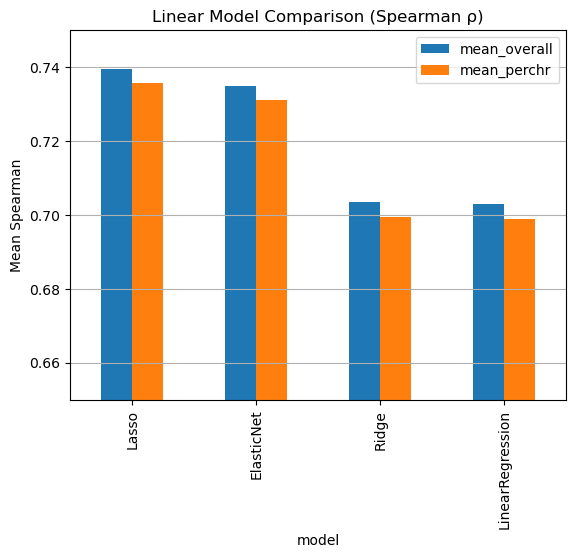

In [5]:
coef = model.named_steps["regressor"].coef_
nonzero = np.sum(coef != 0)
print(f"Non-zero features: {nonzero}/{len(coef)}")
import matplotlib.pyplot as plt

summary_df.plot(x="model", y=["mean_overall", "mean_perchr"], kind="bar")
plt.title("Linear Model Comparison (Spearman ρ)")
plt.ylabel("Mean Spearman")
plt.ylim(0.65, 0.75)
plt.grid(axis="y")
plt.show()


In [ ]:
import optuna
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings, json, os, random

warnings.filterwarnings("ignore")

# ============================================================
#                  CONFIGURATION
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_COL = "gex_rank"

SAVE_DIR = "../results/linear_models/Lasso/optuna"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
#                  LOAD DATA
# ============================================================
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

df_all = pd.concat([df_train, df_val], ignore_index=True)
chromosomes = sorted(df_all["chr"].unique())

print(f"🧬 Total chromosomes in dataset: {chromosomes}")
print(f"Total samples: {len(df_all):,}")

feature_cols = [c for c in df_all.columns if c not in META_COLS]

# ============================================================
#                  OBJECTIVE FUNCTION
# ============================================================
def objective(trial):
    """Optuna objective: tune alpha for Lasso regression"""
    
    # 固定 chr6, chr13 + 隨機抽另外兩條作為 validation
    fixed_val_chrs = ["chr6", "chr13"]
    remaining_chrs = [c for c in chromosomes if c not in fixed_val_chrs]
    rng = random.Random(SEED + trial.number)
    random_extra = rng.sample(remaining_chrs, 2)
    val_chrs = fixed_val_chrs + random_extra
    print(f"Validation chromosomes for this trial: {val_chrs}")

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train_fold = df_all[df_all["chr"].isin(train_chrs)].copy()
    df_val_fold   = df_all[df_all["chr"].isin(val_chrs)].copy()

    X_train, y_train = df_train_fold[feature_cols].values, df_train_fold[TARGET_COL].values
    X_val, y_val     = df_val_fold[feature_cols].values, df_val_fold[TARGET_COL].values

    # Optuna 搜尋超參數
    alpha = trial.suggest_float("alpha", 1e-6, 1.0, log=True)

    # Lasso 模型 + 標準化
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, random_state=SEED, max_iter=20000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Spearman correlation 評估
    rho_overall = spearmanr(y_val, y_pred)[0]

    # 每個 chromosome 的平均 Spearman
    per_chr_rho = []
    for chrom, subdf in df_val_fold.assign(pred=y_pred).groupby("chr"):
        if len(subdf) > 2:
            per_chr_rho.append(spearmanr(subdf["gex_rank"], subdf["pred"])[0])
    mean_rho = np.nanmean(per_chr_rho)

    return mean_rho if not np.isnan(mean_rho) else rho_overall


# ============================================================
#                  RUN OPTIMIZATION
# ============================================================
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

# ============================================================
#                  SAVE RESULTS
# ============================================================
print("✅ Best Spearman:", study.best_value)
print("🏆 Best Parameters:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

study.trials_dataframe().to_csv(os.path.join(SAVE_DIR, "trials_log.csv"), index=False)
with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=4)

print(f"💾 Saved best params and log to {SAVE_DIR}")
import optuna
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings, json, os, random

warnings.filterwarnings("ignore")

# ============================================================
#                  CONFIGURATION
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_COL = "gex_rank"

SAVE_DIR = "../results/lasso/optuna_fixed_chr6_chr13"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
#                  LOAD DATA
# ============================================================
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

df_all = pd.concat([df_train, df_val], ignore_index=True)
chromosomes = sorted(df_all["chr"].unique())

print(f"🧬 Total chromosomes in dataset: {chromosomes}")
print(f"Total samples: {len(df_all):,}")

feature_cols = [c for c in df_all.columns if c not in META_COLS]

# ============================================================
#                  OBJECTIVE FUNCTION
# ============================================================
def objective(trial):
    """Optuna objective: tune alpha for Lasso regression"""
    
    # 固定 chr6, chr13 + 隨機抽另外兩條作為 validation
    fixed_val_chrs = ["chr6", "chr13"]
    remaining_chrs = [c for c in chromosomes if c not in fixed_val_chrs]
    rng = random.Random(SEED + trial.number)
    random_extra = rng.sample(remaining_chrs, 2)
    val_chrs = fixed_val_chrs + random_extra
    print(f"Validation chromosomes for this trial: {val_chrs}")

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train_fold = df_all[df_all["chr"].isin(train_chrs)].copy()
    df_val_fold   = df_all[df_all["chr"].isin(val_chrs)].copy()

    X_train, y_train = df_train_fold[feature_cols].values, df_train_fold[TARGET_COL].values
    X_val, y_val     = df_val_fold[feature_cols].values, df_val_fold[TARGET_COL].values

    # Optuna 搜尋超參數
    alpha = trial.suggest_float("alpha", 1e-6, 1.0, log=True)

    # Lasso 模型 + 標準化
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, random_state=SEED, max_iter=10000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Spearman correlation 評估
    rho_overall = spearmanr(y_val, y_pred)[0]

    # 每個 chromosome 的平均 Spearman
    per_chr_rho = []
    for chrom, subdf in df_val_fold.assign(pred=y_pred).groupby("chr"):
        if len(subdf) > 2:
            per_chr_rho.append(spearmanr(subdf["gex_rank"], subdf["pred"])[0])
    mean_rho = np.nanmean(per_chr_rho)

    return mean_rho if not np.isnan(mean_rho) else rho_overall


# ============================================================
#                  RUN OPTIMIZATION
# ============================================================
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

study.optimize(objective, n_trials=300, show_progress_bar=True)

# ============================================================
#                  SAVE RESULTS
# ============================================================
print("✅ Best Spearman:", study.best_value)
print("🏆 Best Parameters:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

study.trials_dataframe().to_csv(os.path.join(SAVE_DIR, "trials_log.csv"), index=False)
with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=4)

print(f"💾 Saved best params and log to {SAVE_DIR}")


c:\Users\wani\AppData\Local\anaconda3\envs\ML4genomics_project1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-14 12:27:00,197] A new study created in memory with name: no-name-d4ef4734-b774-456f-924a-1a7fb3993ec0


🧬 Total chromosomes in dataset: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
Total samples: 32,568


  0%|          | 0/100 [00:00<?, ?it/s]

Validation chromosomes for this trial: ['chr6', 'chr13', 'chr14', 'chr10']


Best trial: 0. Best value: 0.724624:   1%|          | 1/100 [01:04<1:45:45, 64.10s/it]

[I 2025-10-14 12:28:04,293] Trial 0 finished with value: 0.7246238819104216 and parameters: {'alpha': 0.00017670169402947956}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr11', 'chr2']


Best trial: 0. Best value: 0.724624:   2%|▏         | 2/100 [01:04<43:24, 26.58s/it]  

[W 2025-10-14 12:28:04,608] Trial 1 failed with parameters: {'alpha': 0.5061576888752307} because of the following error: The value nan is not acceptable.
[W 2025-10-14 12:28:04,613] Trial 1 failed with value nan.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr3', 'chr7']


Best trial: 0. Best value: 0.724624:   3%|▎         | 3/100 [01:06<24:56, 15.43s/it]

[I 2025-10-14 12:28:06,778] Trial 2 finished with value: 0.7003585978203163 and parameters: {'alpha': 0.02465832945854911}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr19', 'chr3']


Best trial: 0. Best value: 0.724624:   4%|▍         | 4/100 [01:10<17:29, 10.93s/it]

[I 2025-10-14 12:28:10,808] Trial 3 finished with value: 0.717461963783772 and parameters: {'alpha': 0.003907967156822882}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr12', 'chr22']


Best trial: 4. Best value: 0.724939:   5%|▌         | 5/100 [03:39<1:35:54, 60.57s/it]

[I 2025-10-14 12:30:39,407] Trial 4 finished with value: 0.7249392595012281 and parameters: {'alpha': 8.63200816860254e-06}. Best is trial 4 with value: 0.7249392595012281.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr21', 'chr12']
